In [1]:
import os
import glob

import DESutils
import GPRutils
import vK2KGPR
import plotGPR
import vK2KGPR
import vonkarmanFT as vk

import numpy as np
import astropy.units as u
import astropy.table as tb
from astropy.time import Time
import matplotlib.pyplot as plt
plt.style.use('~/GitHub/custom-matplotlib/custom.mplstyle')
import astropy.stats as stats
from scipy.signal import savgol_filter
import scipy.linalg
import astropy.coordinates as co

from IPython import embed
from importlib import reload
import warnings
warnings.filterwarnings("ignore")

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
eris = tb.Table.read("/home/fortino/DESworkspace/data/GPR.eris.fits")
erisNoY = eris[eris["BAND"] != "Y"]
erisNoY.sort("MJD_OBS")

eris_res_dx = np.array([
    -1.7 ,   3.59,  -7.46,   7.45,  -2.83,   3.12,   0.96,   3.86, 1.78,
     2.24,   0.31,   1.04,  -3.27,  -2.58,  -5.07,  -0.01,  -5.34, -2.46, 
    -4.68,  -3.02,   7.51,   2.43,   1.  ,   5.04,  12.5 ,   9.66, -10.67])*u.mas

eris_res_dy = np.array([
     2.74, 12.67, -4.71, -0.45, -4.71,  3.52, -8.55, -2.65,  4.96,
     6.61,  0.57, -6.79,  3.06, -1.41, -5.99,  0.62,  2.62, -3.18,
    -0.37, 10.48, -2.34,  4.03, -4.66, -3.8 , 12.63,  9.61, -6.21])*u.mas

T = np.array([
    -840.69, -819.78, -818.88, -796.94, -455.75, -455.75, -455.74,
    -423.83, -398.91, -380.97, -351.03,  -14.  ,  -13.95,    0.  ,
       0.  ,  238.27,  241.27,  330.06,  332.08,  333.05,  340.99,
     641.11,  667.17,  667.17,  688.07,  688.07,  995.27])*u.day

DX = tb.Column(data=eris_res_dx, name="ERIS_RES_DX")
DY = tb.Column(data=eris_res_dy, name="ERIS_RES_DY")
T = tb.Column(data=T, name="T")

erisNoY.add_columns([DX, DY, T])
erisNoY.info()

<Table length=27>
     name      dtype  shape  unit                                                description                                                
------------- ------- ------ ---- ----------------------------------------------------------------------------------------------------------
           RA float64                                                                                                                       
          DEC float64                                                                                                                       
   XWIN_IMAGE float64                                                                                                                       
   YWIN_IMAGE float64                                                                                                                       
          MAG float64                                                                                                                   

In [3]:
times = (np.array(erisNoY["T"])*u.day).to(u.year).value
times += np.abs(np.min(times))
time_labels = [f"{time:.2f}" for time in times]
x = np.arange(len(times))

dx = np.array(erisNoY["ERIS_RES_DX"])
dy = np.array(erisNoY["ERIS_RES_DY"])
err = (np.array(erisNoY["ERRAWIN_WORLD"])*u.deg).to(u.mas).value
xi0_002_GPR = np.array(erisNoY["xi0_002_GPR"])
xi0_05_GPR = np.array(erisNoY["xi0_05_GPR"])

5.178214441397478
5.869909036668749


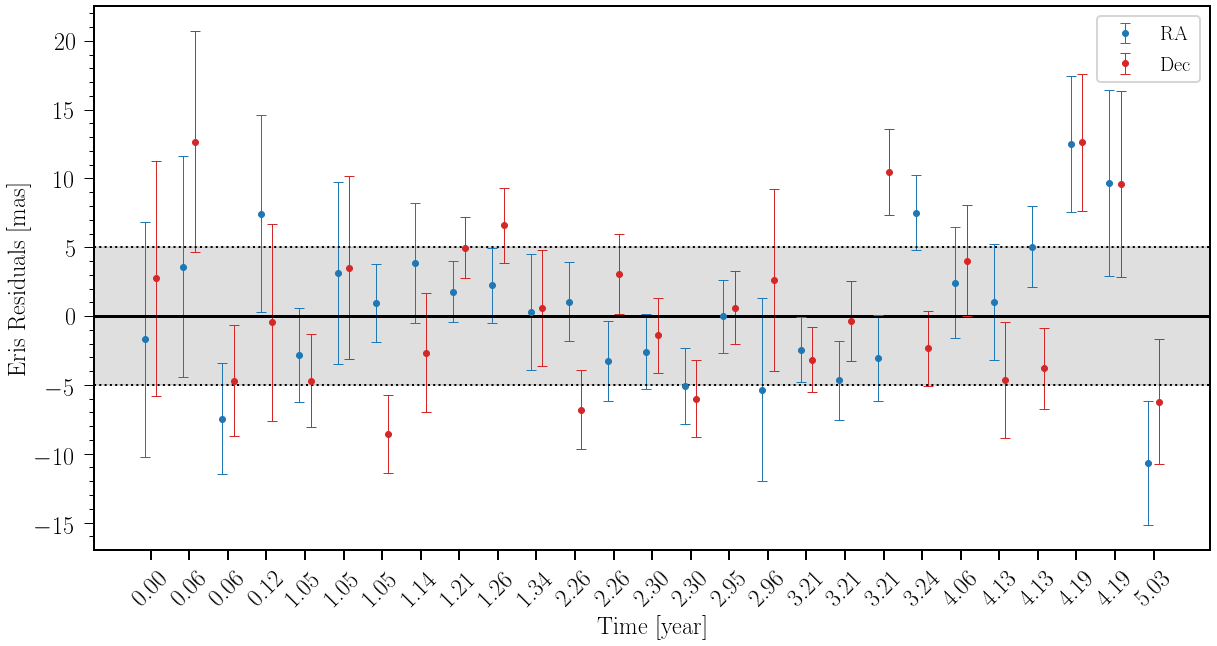

In [4]:
plt.figure(figsize=(20, 10))

plt.axhline(0., lw=3)


rms = np.std(dx)
print(rms)
rms = np.std(dy)
print(rms)

plt.errorbar(
    x-0.15, dx,
    yerr=np.sqrt(err + xi0_002_GPR/2),
    c="tab:blue", marker="o", ls="",
    linewidth=1, capsize=5,
    label="RA")
plt.errorbar(
    x+0.15, dy,
    yerr=np.sqrt(err + xi0_002_GPR/2),
    c="tab:red", marker="o", ls="",
    linewidth=1, capsize=5,
    label="Dec")
plt.xticks(ticks=x, labels=time_labels, rotation=45)
plt.tick_params(
    axis='x',
    which='minor',
    bottom=False,
    top=False)
# plt.xticks

# plt.errorbar(
#     times, dx,
#     yerr=np.sqrt(err + xi0_002_GPR/2),
#     c="tab:blue", marker="o", ls="",
#     linewidth=1, capsize=5,
#     label="RA")

# plt.errorbar(
#     times, dy,
#     yerr=np.sqrt(err + xi0_002_GPR/2),
#     c="tab:red", marker="o", ls="",
#     linewidth=1, capsize=5,
#     label="Dec")

plt.xlim((None, None))
plt.ylim((None, None))
# plt.ylim((-12, 18))

plt.axhline(y=5, c="k", ls=":")
plt.axhline(y=-5, c="k", ls=":")
plt.fill_between(np.linspace(-2*len(x), 2*len(x), 3), 5, -5, alpha=0.25, color="gray")


plt.xlabel("Time [year]")
plt.ylabel(r"Eris Residuals [mas]")

plt.legend(loc="upper right")
# plt.grid(which="major", axis="both", alpha=0.75)
# plt.grid(which="minor", axis="y", alpha=0.75)
plt.savefig("/home/fortino/erisResiduals.pdf")
plt.show()